# Voice Recognition -- Data Preparation

## 1. Prepare Speech Audios

Prepare the audios so they don't have any silences, since later we will be chunking the audios and we don't want a silence to be labeled as speech to prevent confusion to the later model.

### 1.1. Detecting/Removing Silence

In [2]:
import librosa
from pydub import AudioSegment
import matplotlib.pyplot as plt
import os

def detect_silences(audio_path, threshold_db=-40, min_silence_duration=0.5):
    # Load the audio file
    audio, sample_rate = librosa.load(audio_path)

    # Calculate the energy of each frame
    frame_energy = librosa.feature.rms(y=audio, frame_length=2048, hop_length=512)[0]

    # Convert energy to dB scale
    frame_energy_db = librosa.amplitude_to_db(frame_energy)

    # Set the threshold in dB
    threshold = threshold_db

    # Initialize variables
    is_silence = False
    silence_start = 0
    silence_segments = []

    # Iterate over the frames
    for i, energy_db in enumerate(frame_energy_db):
        if energy_db < threshold:
            # If below the threshold, mark as silence
            if not is_silence:
                silence_start = i
                is_silence = True
        else:
            # If above the threshold, mark as non-silence
            if is_silence:
                silence_duration = (i - silence_start) * (512 / sample_rate)
                if silence_duration >= min_silence_duration:
                    # Add the silence segment to the list
                    silence_segments.append((silence_start * 512 / sample_rate, i * 512 / sample_rate))
                is_silence = False

    # Check if the last segment is silence
    if is_silence:
        silence_duration = (i - silence_start) * (512 / sample_rate)
        if silence_duration >= min_silence_duration:
            # Add the silence segment to the list
            silence_segments.append((silence_start * 512 / sample_rate, i * 512 / sample_rate))

    return silence_segments

def remove_silences(input_audio_path, output_audio_path, threshold_db=-40, min_silence_duration=0.5):
    # Load the audio file
    audio = AudioSegment.from_file(input_audio_path)

    # Get the detected silence segments
    silence_segments = detect_silences(input_audio_path, threshold_db, min_silence_duration)

    # Remove the silence segments from the audio
    previous_duration = 0
    for segment in silence_segments:
        start_time = int(segment[0] * 1000) - previous_duration
        end_time = int(segment[1] * 1000) - previous_duration
        audio = audio[:start_time] + audio[end_time:]
        previous_duration += end_time - start_time

    # Save the modified audio
    dir = './' if os.path.dirname(output_audio_path) == '' else os.path.dirname(output_audio_path)
    os.makedirs(dir, exist_ok=True)
    audio.export(output_audio_path, format="wav")




c:\Users\Aitor\anaconda3\envs\venv\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


Experimentation to see what are a generally good values to eliminate those sciences (based on the dB and the silences' duration)

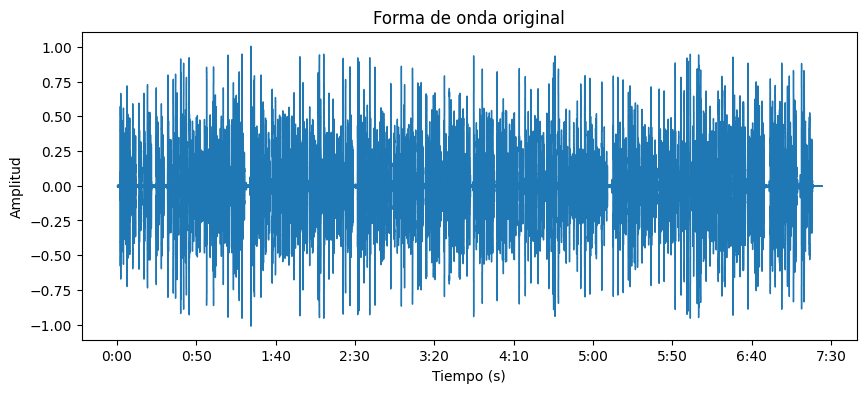

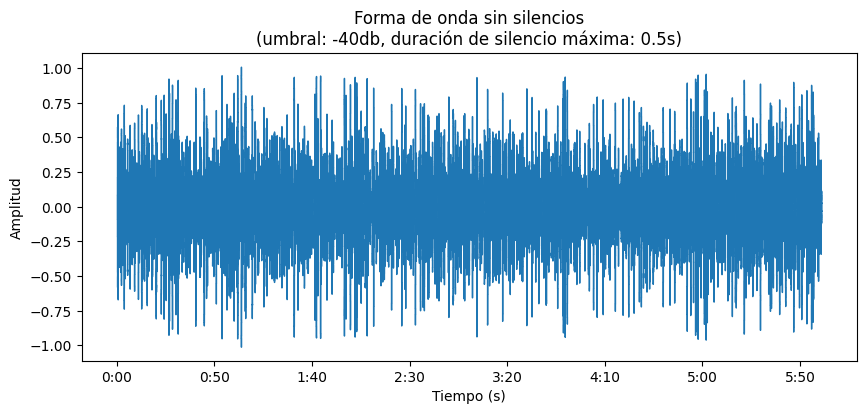

In [3]:

db_threshold = -40 # [-20, -25, -30, -35, -40, -45]
s_threshold = 0.5 # [0, 0.1, 0.2, 0.4, 0.5, 0.7, 1]
output_audio_path = 'speech-librivox-0000_clean.wav'
input_audio_path = 'speech-librivox-0000.wav'
remove_silences(input_audio_path, output_audio_path, db_threshold, s_threshold)
# Plot the waveform
audio, sample_rate = librosa.load(input_audio_path)

plt.figure(figsize=(10, 4))
librosa.display.waveshow(audio, sr=sample_rate)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Forma de onda original')
plt.show()
# Plot the waveform
audio, sample_rate = librosa.load(output_audio_path)

plt.figure(figsize=(10, 4))
librosa.display.waveshow(audio, sr=sample_rate)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title(f'Forma de onda sin silencios\n(umbral: {db_threshold}db, duración de silencio máxima: {s_threshold}s)')
plt.show()

#### 1.2 Cleaning the Actual Speech audios

In [4]:
import os
from tqdm.notebook import tqdm as tqdm
from colorama import Style

db_threshold = -40
s_threshold = 0.5
base_dirs = ["../../musan/musan/speech/us-gov", "../../musan/musan/speech/librivox"]
all_paths = []
for base_dir in base_dirs:
    all_paths += [os.path.normpath(os.path.join(base_dir, f_path)) for f_path in os.listdir(base_dir) if f_path.endswith('wav')]

k = len(all_paths)
progress_bar = tqdm(total=k, desc="Cleaning Audios", bar_format="{desc}  {bar}  " + Style.RESET_ALL+"{percentage:3.3f}% ({n_fmt}/{total_fmt}) [{elapsed}<{remaining}]", ncols=120, ascii=" ╸╸╸╸┅┅┅┅━━━━")
for i, file_path in enumerate(all_paths):
    progress_bar.update(1)
    # Shifting color from red to green
    color = f"\033[38;2;{int(255 - ((i/k )* 255))};{int((i/k) * 255)};0m"
    progress_bar.set_description_str(desc=f"{Style.RESET_ALL}Cleaning Audios: {color}")
    
    input_audio_path = file_path
    output_audio_path = os.path.join(os.path.dirname(input_audio_path), 'clean', os.path.basename(input_audio_path))
    remove_silences(input_audio_path, output_audio_path, db_threshold, s_threshold)
    
progress_bar.close()

Cleaning Audios                                                                                 0.000% (0/…

## 3. Generation of Data Sets

In [5]:
import os
import pandas as pd
import soundfile as sf
from tqdm.notebook import tqdm as tqdm
from colorama import Style

def flatten_list(nested_list):
    flattened_list = []
    for item in nested_list:
        if isinstance(item, list):
            flattened_list.extend(flatten_list(item))
        else:
            flattened_list.append(item)
    return flattened_list

def get_audio_duration(audio_path):
    with sf.SoundFile(audio_path) as audio_file:
        duration = len(audio_file) / audio_file.samplerate

    return duration

# Function to generate all possible chunks for a given audio duration
def generate_audio_chunks(duration, chunk_length):
    num_chunks = int(duration // chunk_length)
    chunks = [(i * chunk_length, (i + 1) * chunk_length) for i in range(num_chunks)]
    
    return chunks

def generate_data_set(speech_folder_list, non_speech_folder_list, chunk_length):

    # Create empty lists to store the data
    file_paths = []
    start_times = []
    end_times = []
    labels = []

    all_files = [os.listdir(speech_folder) for speech_folder in speech_folder_list]
    all_files += [os.listdir(non_speech_folder) for non_speech_folder in non_speech_folder_list]
    all_files = flatten_list(all_files)

    k = len(all_files)
    i = 0
    progress_bar = tqdm(total=k, desc="Creating DataSet", bar_format="{desc}  {bar}  " + Style.RESET_ALL+"{percentage:3.3f}% ({n_fmt}/{total_fmt}) [{elapsed}<{remaining}]", ncols=120, ascii=" ╸╸╸╸┅┅┅┅━━━━")

    # Process the speech files
    for speech_folder in speech_folder_list:
        for file in os.listdir(speech_folder):
            color = f"\033[38;2;{int(255 - ((i/k )* 255))};{int((i/k) * 255)};0m"
            progress_bar.set_description_str(desc=f"{Style.RESET_ALL}Creating DataSet: {color}")

            file_path = os.path.normpath(os.path.join(speech_folder, file))
            audio_duration = get_audio_duration(file_path)  
            chunks = generate_audio_chunks(audio_duration, chunk_length)  
            for chunk in chunks:
                file_paths.append(file_path)
                start_times.append(chunk[0])
                end_times.append(chunk[1])
                labels.append('speech')

            progress_bar.update(1)
            i += 1


    # Process the non-speech files
    for non_speech_folder in non_speech_folder_list:
        for file in os.listdir(non_speech_folder):
            color = f"\033[38;2;{int(255 - ((i/k )* 255))};{int((i/k) * 255)};0m"
            progress_bar.set_description_str(desc=f"{Style.RESET_ALL}Creating DataSet: {color}")

            file_path = os.path.normpath(os.path.join(non_speech_folder, file))
            audio_duration = get_audio_duration(file_path)  
            chunks = generate_audio_chunks(audio_duration, chunk_length)  
            for chunk in chunks:
                file_paths.append(file_path)
                start_times.append(chunk[0])
                end_times.append(chunk[1])
                labels.append('non-speech')

            progress_bar.update(1)
            i += 1

    progress_bar.close()

    # Create the pandas DataFrame
    data = {
        'file_path': file_paths,
        'start_time': start_times,
        'end_time': end_times,
        'label': labels
    }
    df = pd.DataFrame(data)

    return df





#### 3.2 Generation of a Data Set out of the audios at disposal

In [6]:

# Listing the 'speech' and 'non-speech' folders
speech_folder_list = ['data/speech/librivox', 'data/speech/us-gov']
non_speech_folder_list = ['data/noise/free-sound', 'data/noise/sound-bible']

chunk_length = 3   # measured in seconds

# Generate the Data Set
df = generate_data_set(speech_folder_list, non_speech_folder_list, chunk_length)

# Print the DataFrame
display(df)
print(sum(df.label == 'speech'))
print(sum(df.label == 'non-speech'))

# Save the DataFrame
output_file = 'speech_non-speech_dataset.csv'
df.to_csv(output_file, index=False)


Creating DataSet                                                                               0.000% (0/1…

,file_path,start_time,end_time,label
0,data\speech\librivox\speech-librivox-0000.wav,0,3,speech
1,data\speech\librivox\speech-librivox-0000.wav,3,6,speech
2,data\speech\librivox\speech-librivox-0000.wav,6,9,speech
3,data\speech\librivox\speech-librivox-0000.wav,9,12,speech
4,data\speech\librivox\speech-librivox-0000.wav,12,15,speech
...,...,...,...,...
71888,data\noise\sound-bible\noise-sound-bible-0083.wav,48,51,non-speech
71889,data\noise\sound-bible\noise-sound-bible-0083.wav,51,54,non-speech
71890,data\noise\sound-bible\noise-sound-bible-0083.wav,54,57,non-speech
71891,data\noise\sound-bible\noise-sound-bible-0084.wav,0,3,non-speech


64871
7022


## 4. Augmentation of Data Sets

### 4.1 Augmentation functions

#### 4.1.1 Augmentation for Waveforms

   * ##### modulate_volume

<class 'numpy.ndarray'>
48000


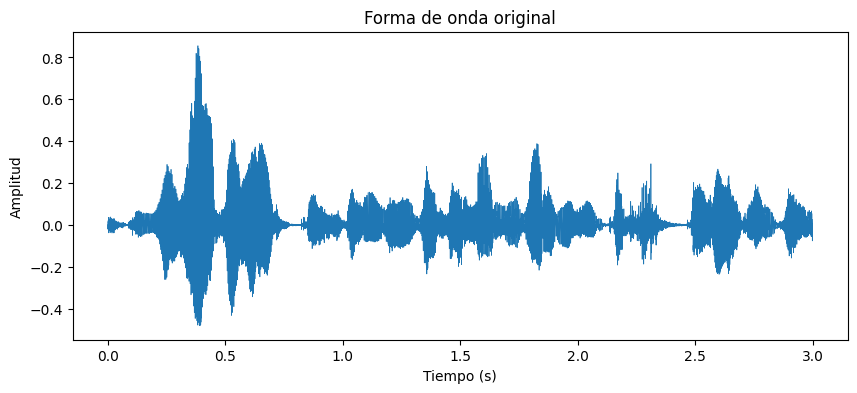

48000


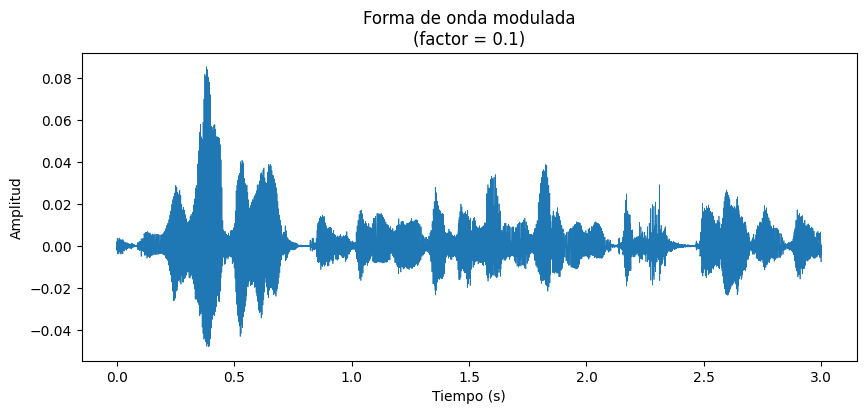

48000


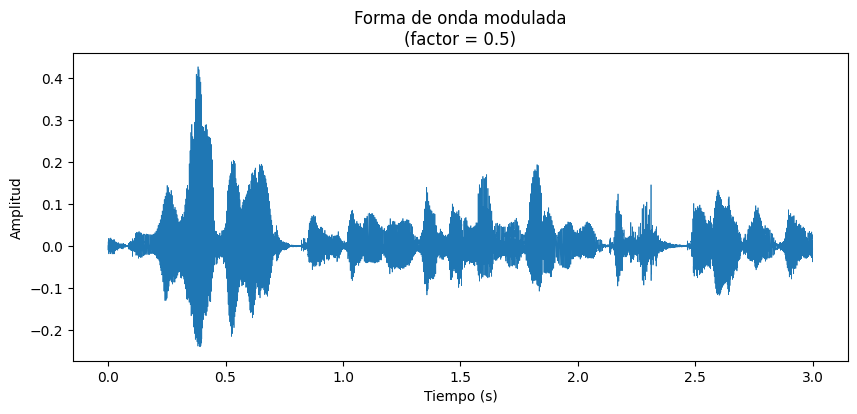

48000


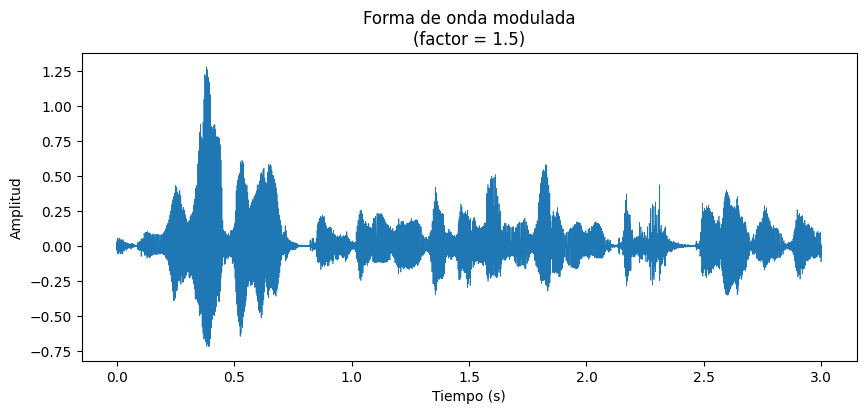

48000


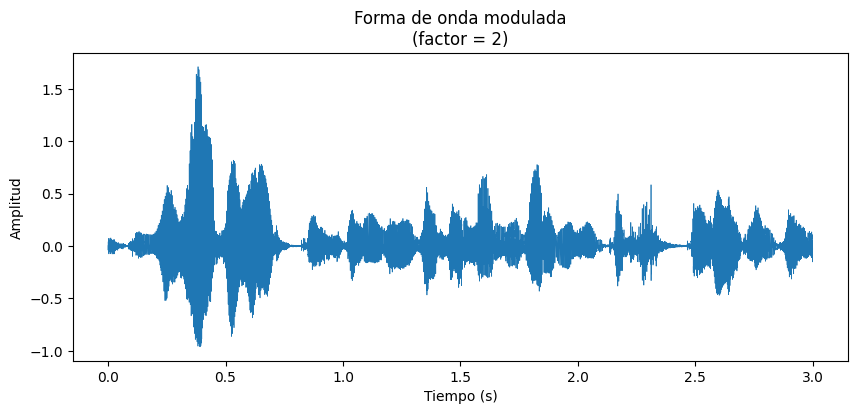

48000


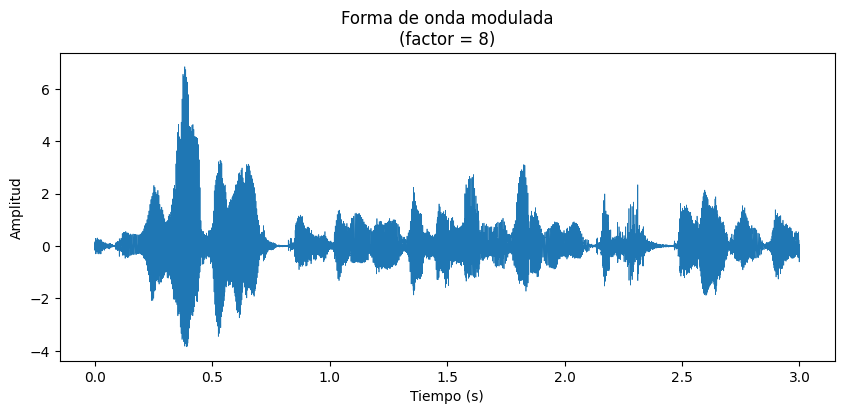

In [4]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from Preprocessing import modulate_volume


sample_rate = 16000
seconds = 3
start = 20
ter_audio, _ = librosa.load('ter.wav', sr=sample_rate)
ter_audio = ter_audio[start*sample_rate:sample_rate*(seconds+start)]

# Mostrar la waveform
print(type(ter_audio))
print(len(ter_audio))
tiempo = np.arange(len(ter_audio)) / sample_rate
plt.figure(figsize=(10, 4))
plt.plot(tiempo, ter_audio, linewidth=0.5)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Forma de onda original')
plt.show()


for factor in [0.1, 0.5, 1.5, 2, 8]:
    # Usage:
    audio = ter_audio.copy()  # Load the audio sample
    modulated_audio = modulate_volume(audio, factor)

    sf.write(f'modulate_volume_{factor}.wav', modulated_audio, sample_rate, subtype='PCM_24')

    # Mostrar la waveform
    print(len(modulated_audio))
    tiempo = np.arange(len(modulated_audio)) / sample_rate
    plt.figure(figsize=(10, 4))
    plt.plot(tiempo, modulated_audio, linewidth=0.5)
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.title(f'Forma de onda modulada\n(factor = {factor})')
    plt.show()

* ##### time_stretch

<class 'numpy.ndarray'>
48000


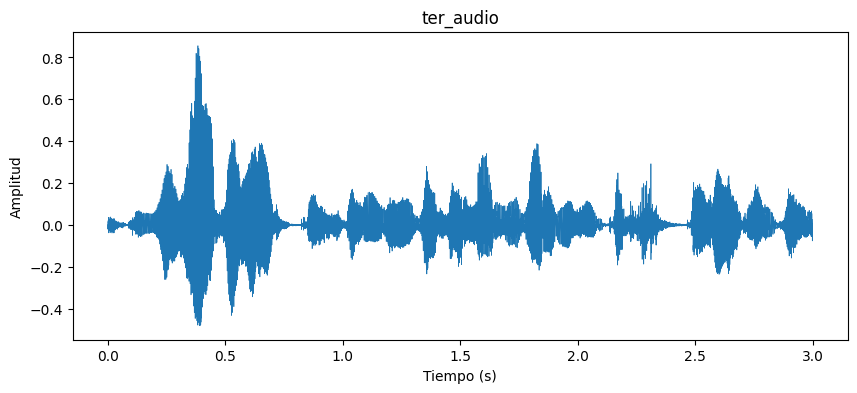

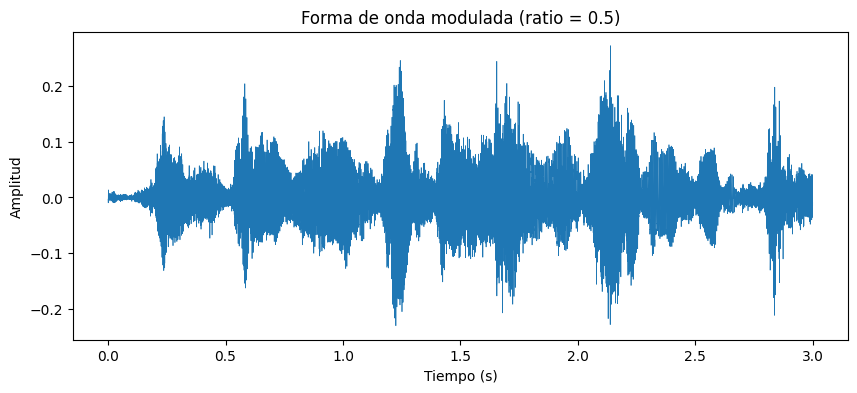

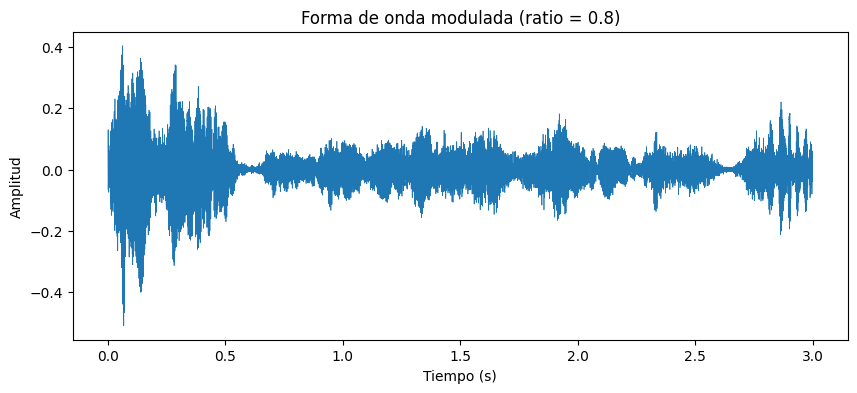

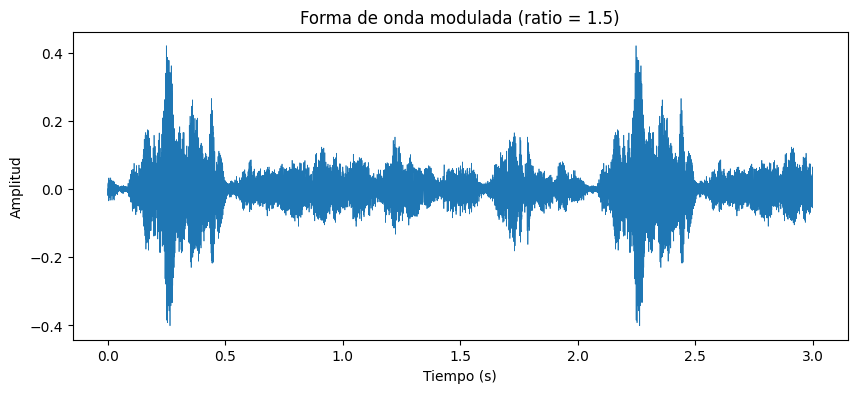

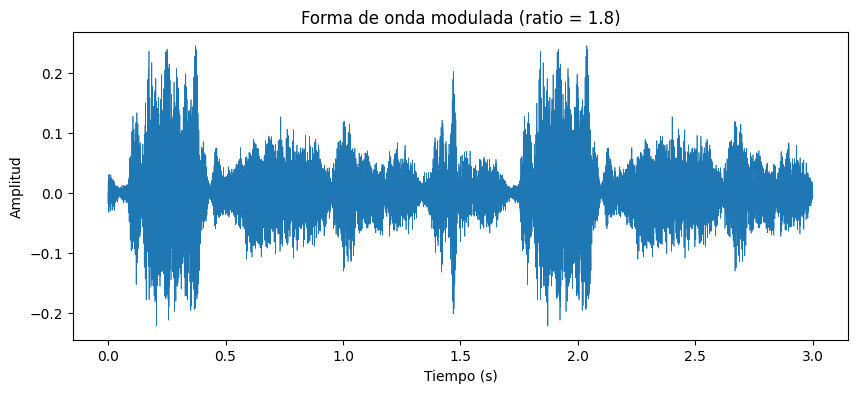

[0.04932031 0.05974197 0.05401577 ... 0.00293472 0.01102784 0.01345496] 48000


In [5]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from Preprocessing import time_stretch


sample_rate = 16000
seconds = 3
start = 20
ter_audio, _ = librosa.load('ter.wav', sr=sample_rate)
ter_audio = ter_audio[start*sample_rate:sample_rate*(seconds+start)]

# Mostrar la waveform
print(type(ter_audio))
print(len(ter_audio))
tiempo = np.arange(len(ter_audio)) / sample_rate
plt.figure(figsize=(10, 4))
plt.plot(tiempo, ter_audio, linewidth=0.5)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('ter_audio')
plt.show()


for rate in [0.5, 0.8, 1.5, 1.8]:
    # Usage:
    audio = ter_audio.copy()  # Load the audio sample
    stretched_audio = time_stretch(audio, rate)

    sf.write(f'time_stretch_{rate}.wav', stretched_audio, sample_rate, subtype='PCM_24')

    # Mostrar la waveform
    tiempo = np.arange(len(stretched_audio)) / sample_rate
    plt.figure(figsize=(10, 4))
    plt.plot(tiempo, stretched_audio, linewidth=0.5)
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.title(f'Forma de onda modulada (ratio = {rate})')
    plt.show()

audio_file = 'data/speech/us-gov/speech-us-gov-0103.wav'
start_time = 351
duration = 3
sample_rate = 16000
audio_data, sample_rate = librosa.load(audio_file, sr=sample_rate, offset=start_time, duration=duration)
stretch = time_stretch(audio_data, 0.5)
print(stretch, len(stretch))

* ##### pitch_shift

<class 'numpy.ndarray'>
48000


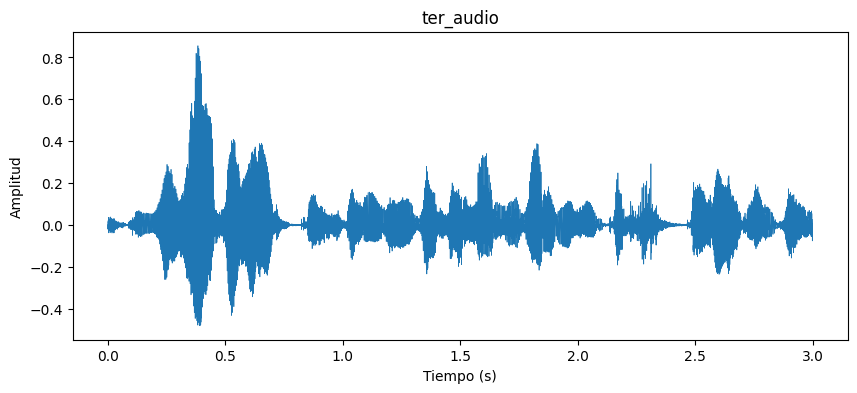

48000


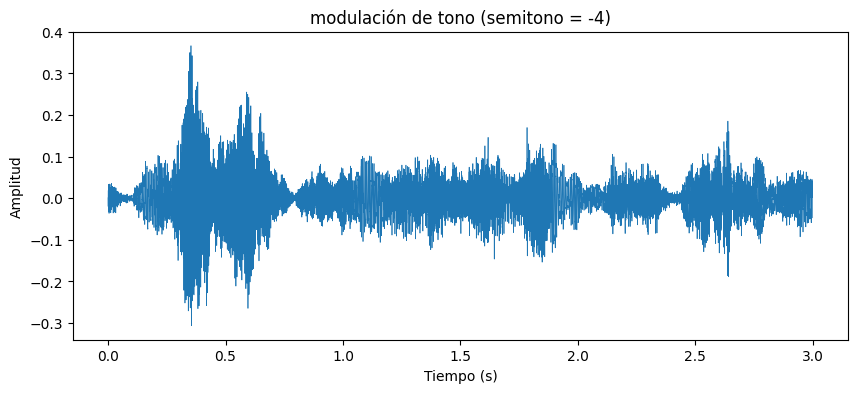

48000


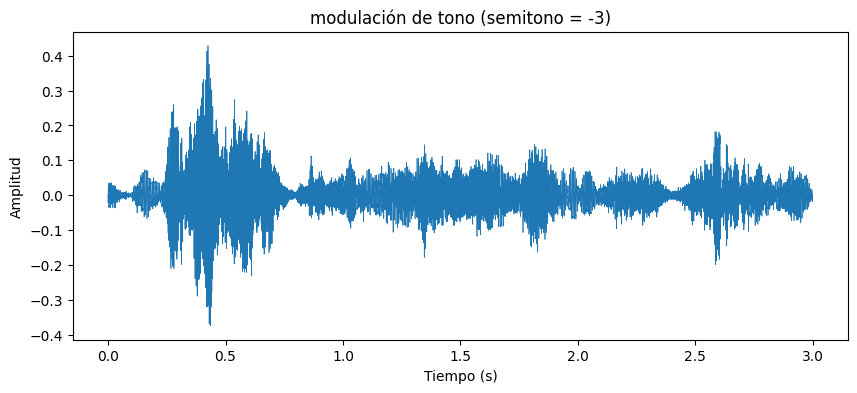

48000


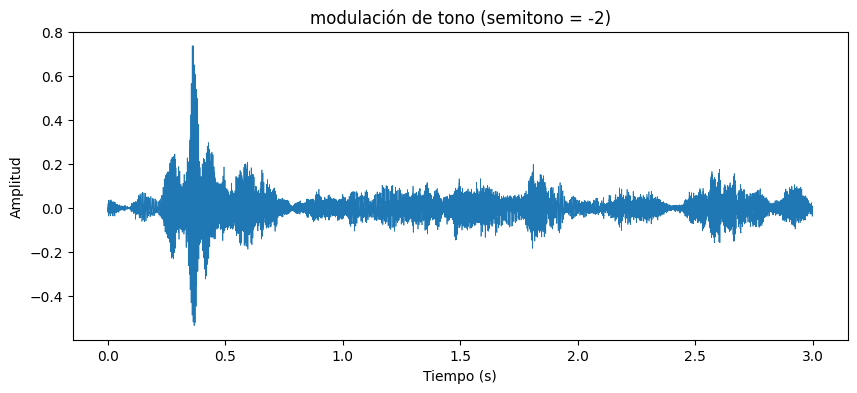

48000


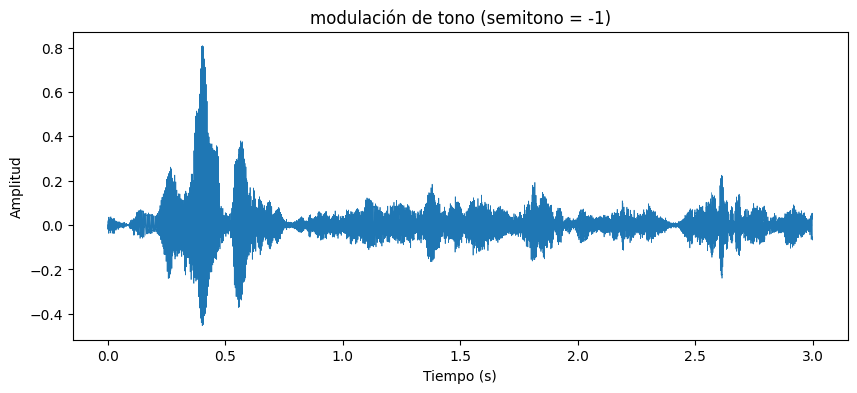

48000


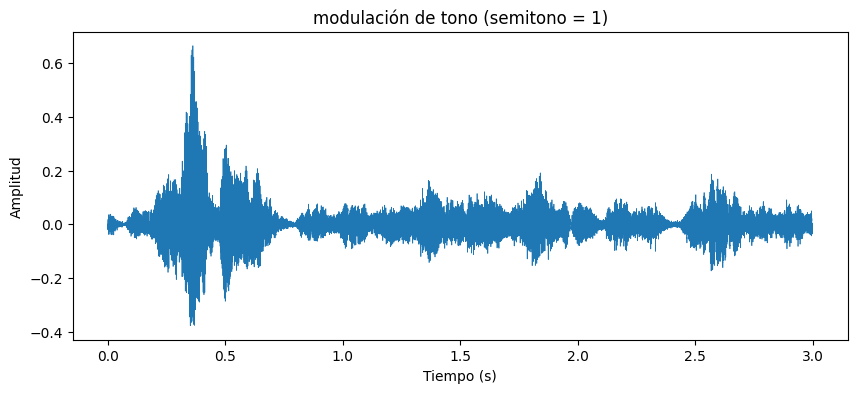

48000


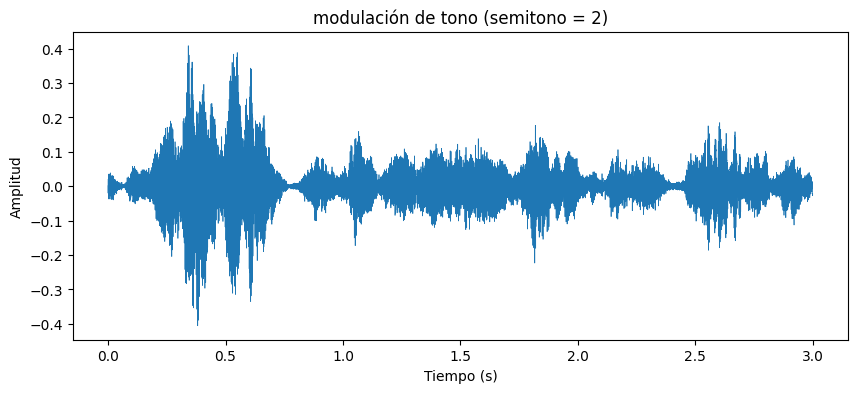

48000


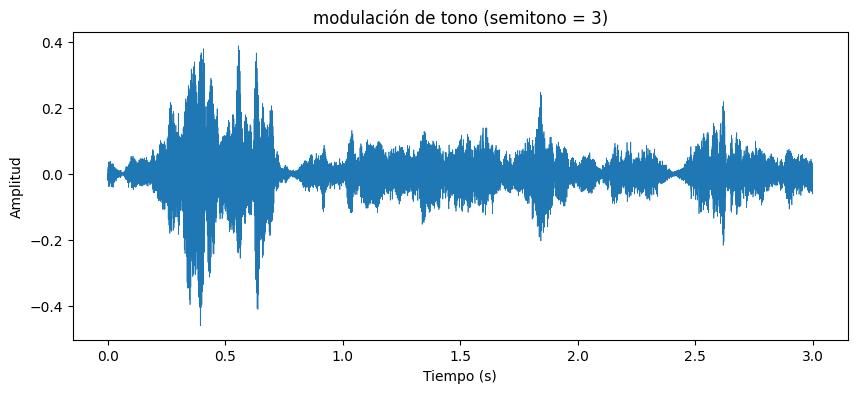

48000


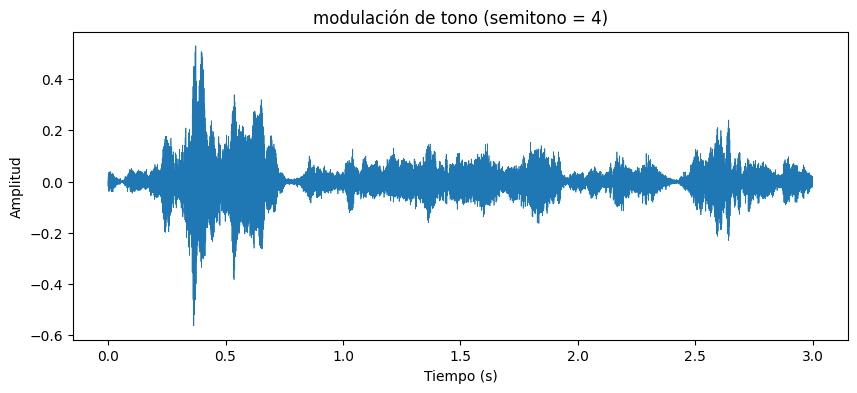

In [20]:

import librosa
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from Preprocessing import pitch_shift


sample_rate = 16000
seconds = 3
start = 20
ter_audio, _ = librosa.load('ter.wav', sr=sample_rate)
ter_audio = ter_audio[start*sample_rate:sample_rate*(seconds+start)]

# Mostrar la waveform
print(type(ter_audio))
print(len(ter_audio))
tiempo = np.arange(len(ter_audio)) / sample_rate
plt.figure(figsize=(10, 4))
plt.plot(tiempo, ter_audio, linewidth=0.5)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('ter_audio')
plt.show()


for semi_tone in [-4, -3, -2, -1, 1, 2, 3, 4]:
    # Usage:
    audio = ter_audio.copy()  # Load the audio sample
    shifted_audio = pitch_shift(audio, sample_rate, semi_tone)


    # Mostrar la waveform
    print(len(shifted_audio))
    tiempo = np.arange(len(shifted_audio)) / sample_rate
    plt.figure(figsize=(10, 4))
    plt.plot(tiempo, shifted_audio, linewidth=0.5)
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.title(f'modulación de tono (semitono = {semi_tone})')
    plt.show()


* ##### merge_noise

<class 'numpy.ndarray'>
48000


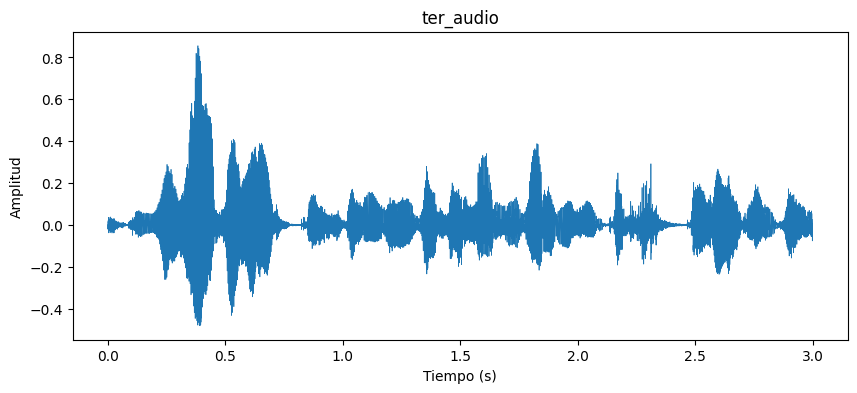

48000


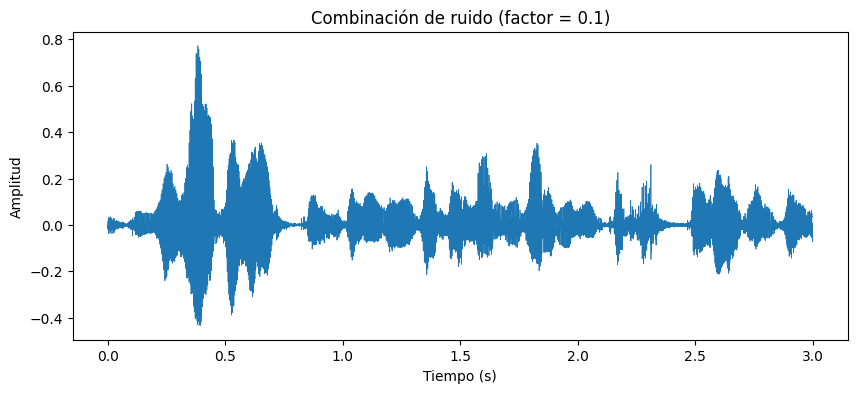

48000


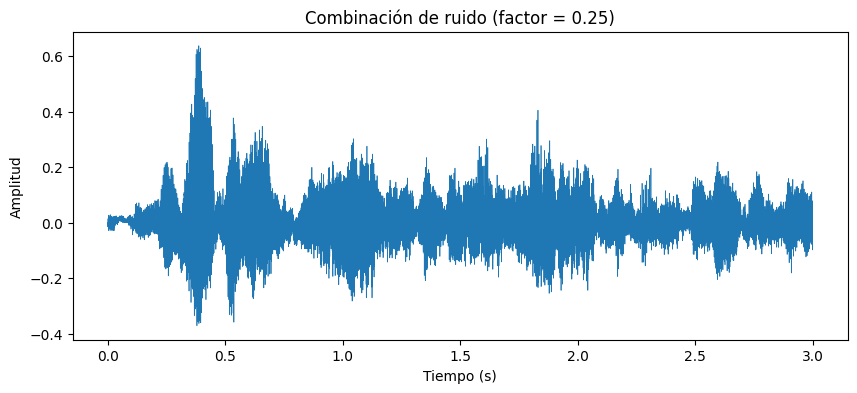

48000


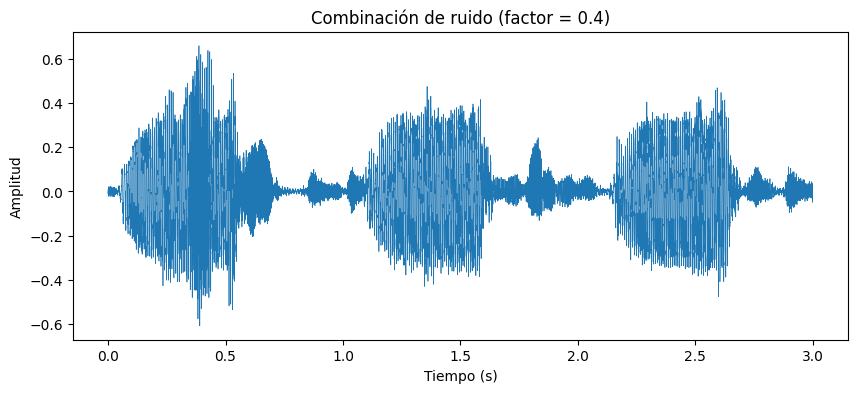

In [21]:

import librosa
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from Preprocessing import merge_noise


sample_rate = 16000
seconds = 3
start = 20
ter_audio, _ = librosa.load('ter.wav', sr=sample_rate)
ter_audio = ter_audio[start*sample_rate:sample_rate*(seconds+start)]

# Mostrar la waveform
print(type(ter_audio))
print(len(ter_audio))
tiempo = np.arange(len(ter_audio)) / sample_rate
plt.figure(figsize=(10, 4))
plt.plot(tiempo, ter_audio, linewidth=0.5)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('ter_audio')
plt.show()



for noise_factor in [0.1, 0.25, 0.4]:
    # Usage:
    audio = ter_audio.copy()  # Load the audio sample
    merge_noisy_audio = merge_noise(audio, sample_rate, noise_factor)


    # Mostrar la waveform
    print(len(merge_noisy_audio))
    tiempo = np.arange(len(merge_noisy_audio)) / sample_rate
    plt.figure(figsize=(10, 4))
    plt.plot(tiempo, merge_noisy_audio, linewidth=0.5)
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.title(f'Combinación de ruido (factor = {noise_factor})')
    plt.show()


* #### colored_noise

<class 'numpy.ndarray'>
48000


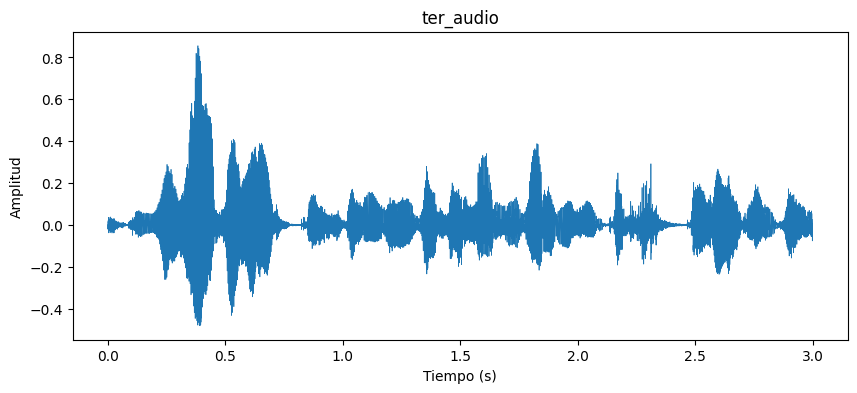

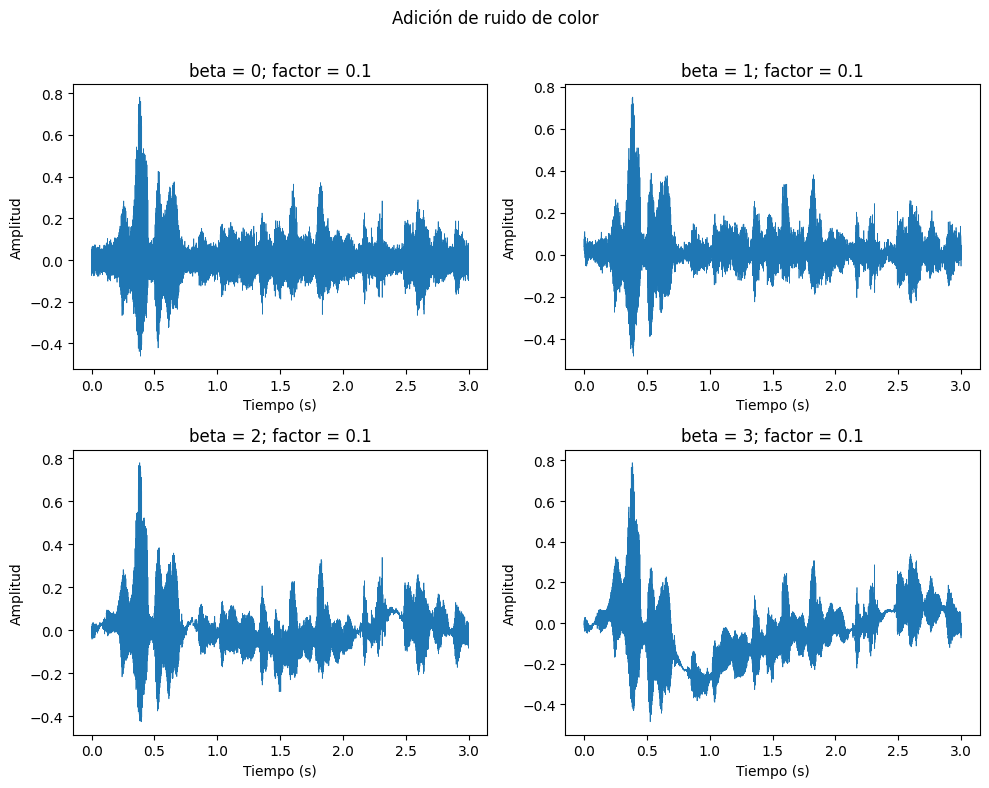

In [34]:

import librosa
import numpy as np
import random
import colorednoise as cn
import os
import matplotlib.pyplot as plt
import soundfile as sf
from Preprocessing import colored_noise


sample_rate = 16000
seconds = 3
start = 20
ter_audio, _ = librosa.load('ter.wav', sr=sample_rate)
ter_audio = ter_audio[start*sample_rate:sample_rate*(seconds+start)]

# Mostrar la waveform
print(type(ter_audio))
print(len(ter_audio))
tiempo = np.arange(len(ter_audio)) / sample_rate
plt.figure(figsize=(10, 4))
plt.plot(tiempo, ter_audio, linewidth=0.5)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('ter_audio')
plt.show()





beta = 0  # Beta gives the 'color' of the noise (0 = 'white'; 1 = 'pink';  2 = 'red')
noise_factor = 0.1
# [0.03, 0.06, 0.1](noise_factor) x [0](beta)
# [0.03, 0.06, 0.1](noise_factor) x [1](beta)
# [0.03, 0.06, 0.1](noise_factor) x [2](beta)
# [0.03, 0.06, 0.1](noise_factor) x [3](beta)

beta_values = [0, 1, 2, 3]
noise_factors = [0.1]

# Create a figure with a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Iterate through beta and noise_factor values
for i, beta in enumerate(beta_values):
    for j, noise_factor in enumerate(noise_factors):
        # Generate colored noisy audio
        random.seed(44)
        colored_noisy_audio = colored_noise(audio, beta, noise_factor)

        # Plot the waveform in the corresponding subplot
        tiempo = np.arange(len(colored_noisy_audio)) / sample_rate
        ax = axes[i//2, i%2]
        ax.plot(tiempo, colored_noisy_audio, linewidth=0.5)
        ax.set_xlabel('Tiempo (s)')
        ax.set_ylabel('Amplitud')
        ax.set_title(f'beta = {beta}; factor = {noise_factor}')

# Adjust layout
plt.suptitle('Adición de ruido de color\n')
plt.tight_layout()

# Show the combined plot
plt.show()



#### 4.1.2 Augmentation for Spectrograms

* ##### spec_augment

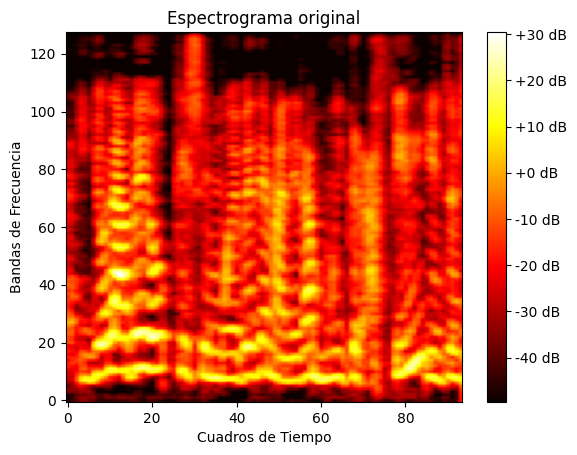

<class 'numpy.ndarray'>
(128, 94)


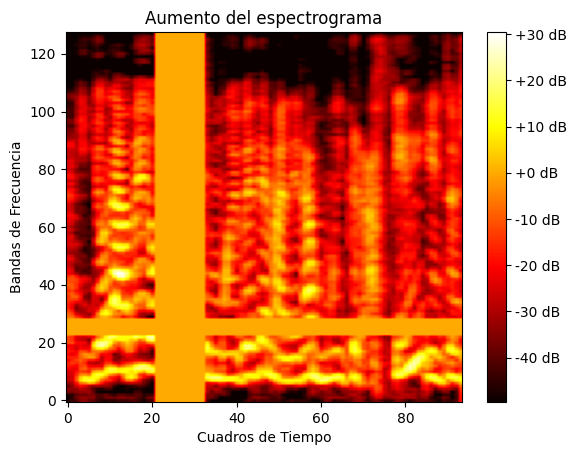

(94, 128)


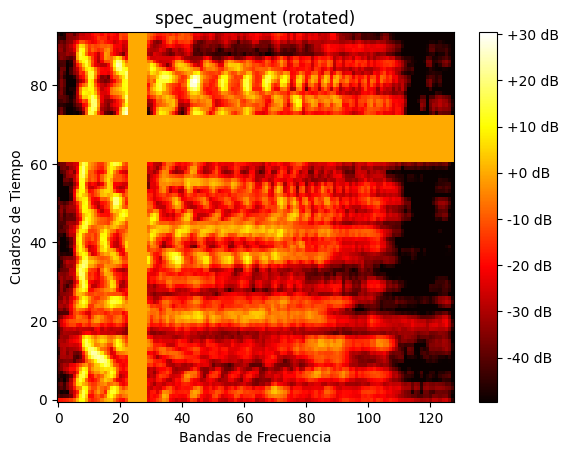

In [36]:
import librosa
import numpy as np
import random
import colorednoise as cn
import os
import matplotlib.pyplot as plt
import soundfile as sf
from Preprocessing import spec_augment


sample_rate = 16000
seconds = 3
start = 20
ter_audio, _ = librosa.load('ter.wav', sr=sample_rate)
ter_audio = ter_audio[start*sample_rate:sample_rate*(seconds+start)]




# Usage:
spectrogram = librosa.feature.melspectrogram(y=ter_audio, sr=sample_rate)
original_melspec = librosa.power_to_db(spectrogram)  # Original mel spectrogram
freq_masking_max_percentage = 0.15  # Maximum percentage of frequency masking
time_masking_max_percentage = 0.3  # Maximum percentage of time masking

# Mostrar la waveform
plt.imshow(original_melspec, cmap='hot', aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f dB')  # Barra de color opcional
plt.xlabel('Cuadros de Tiempo')
plt.ylabel('Bandas de Frecuencia')
plt.title('Espectrograma original')
plt.show()




augmented_melspec = spec_augment(original_melspec, freq_masking_max_percentage, time_masking_max_percentage)

# Show spectrogram
print(type(augmented_melspec))
print(augmented_melspec.shape)
plt.imshow(augmented_melspec, cmap='hot', aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f dB')  # Barra de color opcional
plt.xlabel('Cuadros de Tiempo')
plt.ylabel('Bandas de Frecuencia')
plt.title('Aumento del espectrograma')
plt.show()

rot_mat = np.rot90(augmented_melspec.copy(), k=3, axes=(1,0))
print(rot_mat.shape)
plt.imshow(rot_mat, cmap='hot', aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f dB')  # Barra de color opcional
plt.xlabel('Bandas de Frecuencia')
plt.ylabel('Cuadros de Tiempo')
plt.title('spec_augment (rotated)')
plt.show()


### 4.2 Function to Augment a given DS

In [13]:

def augment_dataset(data_frame, percentage, methods, probabilities, mask):
    my_df = data_frame.copy()
    total = my_df.shape[0]
    size = int(total * percentage)

    method_list = random.choices(list(methods.keys()), probabilities, k=size)

    functs = []
    params = []
    for f in method_list:
        functs.append(f)
        params.append(random.choices(methods[f])[0])

    examples = my_df[mask].sample(size, replace=True)


    df_examples_augment = examples.copy()
    df_examples_augment['functions'] = functs
    df_examples_augment['parameters'] = params

    # Join the dataframes based on common columns
    merged_df = pd.concat([my_df, df_examples_augment], ignore_index=True, sort=False)
    

    return merged_df


### 4.3 Generate Augmented DataSet for WaveForms

In [14]:
from itertools import product
import random

# Listing the 'speech' and 'non-speech' folders
speech_folder_list = ['data/speech/librivox', 'data/speech/us-gov']
non_speech_folder_list = ['data/noise/free-sound', 'data/noise/sound-bible']

# Load the original dataset
csv_file = 'speech_non-speech_dataset.csv'
df = pd.read_csv(csv_file, index_col=None)

methods = {'modulate_volume': [0.1, 0.5, 1.5, 2, 8],
              'time_stretch': [0.5, 0.8, 1.5, 1.8], 
              'pitch_shift': [-4, -3, -2, -1, 1, 2, 3, 4], 
              'merge_noise': [0.1, 0.25, 0.4], 
              'colored_noise': list(product([0.03, 0.06, 0.1], [0, 1, 2, 3]))}
probs = []
total = 0
for key, item in methods.items():
    k = len(item)
    probs.append(k)
    total += k
probs = [p/total for p in probs]

mask = df.label == 'speech'
p_voice = 0.25
df_augment_voice = augment_dataset(df, percentage=p_voice, methods=methods,
                                   probabilities=probs, mask = mask)


s = sum(df.label == 'speech')
n_s = sum(df.label == 'non-speech')

# Balance DataSet (and Augment the same amount of noise as we did with voice)
mask = df.label == 'non-speech'
p_noise = ((s - n_s) / (s + n_s)) + p_voice
df_augment_noise = augment_dataset(df, percentage=p_noise, methods=methods,
                                   probabilities=probs, mask = mask)

df_augment = df_augment_noise.merge(df_augment_voice, how='outer')
df_augment = df_augment.sample(frac=1, random_state=42).reset_index(drop=True)
display(df_augment)

print('speech: ', sum(df_augment.label == 'speech'))
print('non-speech: ', sum(df_augment.label == 'non-speech'))

# Save the DataFrame
output_file = 'waveform_dataset_augmented_balanced.csv'
df_augment.to_csv(output_file, index=False)

,file_path,start_time,end_time,label,functions,parameters
0,data\noise\free-sound\noise-free-sound-0842.wav,261,264,non-speech,time_stretch,1.8
1,data\noise\free-sound\noise-free-sound-0497.wav,240,243,non-speech,colored_noise,"(0.03, 2)"
2,data\noise\free-sound\noise-free-sound-0472.wav,39,42,non-speech,merge_noise,0.1
3,data\noise\free-sound\noise-free-sound-0461.wav,42,45,non-speech,colored_noise,"(0.06, 2)"
4,data\speech\us-gov\speech-us-gov-0036.wav,393,396,speech,pitch_shift,1
...,...,...,...,...,...,...
165683,data\noise\free-sound\noise-free-sound-0427.wav,18,21,non-speech,modulate_volume,0.5
165684,data\noise\free-sound\noise-free-sound-0187.wav,3,6,non-speech,colored_noise,"(0.1, 1)"
165685,data\noise\free-sound\noise-free-sound-0820.wav,12,15,non-speech,colored_noise,"(0.06, 0)"
165686,data\noise\sound-bible\noise-sound-bible-0044.wav,24,27,non-speech,time_stretch,1.5


speech:  82844
non-speech:  82844


### 4.4 Generate Augmented DataSet for Spectrograms

In [15]:
from itertools import product
import random

# Listing the 'speech' and 'non-speech' folders
speech_folder_list = ['data/speech/librivox', 'data/speech/us-gov']
non_speech_folder_list = ['data/noise/free-sound', 'data/noise/sound-bible']

chunk_length = 3   # measured in seconds

# Load the original dataset
csv_file = 'speech_non-speech_dataset.csv'
df = pd.read_csv(csv_file, index_col=None)

methods = {'time_stretch': [0.5, 0.8, 1.5, 1.8], 
            'pitch_shift': [-4, -3, -2, -1, 1, 2, 3, 4], 
            'merge_noise': [0.1, 0.25, 0.4], 
            'colored_noise': list(product([0.03, 0.06, 0.1, 0.3], [0, 1, 2, 3])),
            'spec_augment': [(0.15, 0.3)]}
probs = []
total = 0
for key, item in methods.items():
    k = len(item)
    probs.append(k)
    total += k
probs = [p/total for p in probs]

mask = df.label == 'speech'
p_voice = 0.25
df_augment_voice = augment_dataset(df, percentage=p_voice, methods=methods,
                                   probabilities=probs, mask = mask)


s = sum(df.label == 'speech')
n_s = sum(df.label == 'non-speech')

# Balance DataSet (and Augment the same amount of noise as we did with voice)
mask = df.label == 'non-speech'
p_noise = ((s - n_s) / (s + n_s)) + p_voice
df_augment_noise = augment_dataset(df, percentage=p_noise, methods=methods,
                                   probabilities=probs, mask = mask)

df_augment = df_augment_noise.merge(df_augment_voice, how='outer')
df_augment = df_augment.sample(frac=1, random_state=42).reset_index(drop=True)
display(df_augment)

print('speech: ', sum(df_augment.label == 'speech'))
print('non-speech: ', sum(df_augment.label == 'non-speech'))

# Save the DataFrame
output_file = 'spectrogram_dataset_augmented_balanced.csv'
df_augment.to_csv(output_file, index=False)


,file_path,start_time,end_time,label,functions,parameters
0,data\noise\free-sound\noise-free-sound-0426.wav,0,3,non-speech,colored_noise,"(0.03, 0)"
1,data\noise\free-sound\noise-free-sound-0494.wav,3,6,non-speech,colored_noise,"(0.06, 2)"
2,data\noise\free-sound\noise-free-sound-0644.wav,90,93,non-speech,colored_noise,"(0.1, 3)"
3,data\noise\free-sound\noise-free-sound-0118.wav,3,6,non-speech,pitch_shift,-1
4,data\speech\us-gov\speech-us-gov-0236.wav,186,189,speech,colored_noise,"(0.03, 3)"
...,...,...,...,...,...,...
165683,data\noise\free-sound\noise-free-sound-0443.wav,39,42,non-speech,pitch_shift,-1
165684,data\noise\free-sound\noise-free-sound-0048.wav,63,66,non-speech,spec_augment,"(0.15, 0.3)"
165685,data\noise\free-sound\noise-free-sound-0042.wav,90,93,non-speech,colored_noise,"(0.1, 0)"
165686,data\noise\free-sound\noise-free-sound-0770.wav,21,24,non-speech,colored_noise,"(0.03, 3)"


speech:  82844
non-speech:  82844


<class 'numpy.ndarray'>
(48000,)


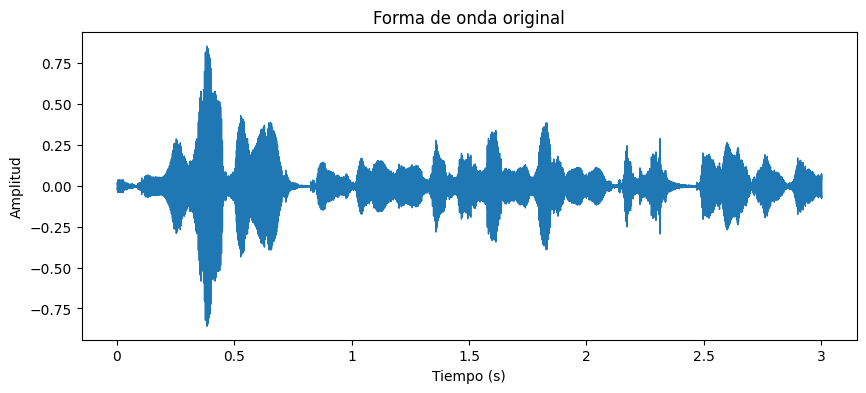

<class 'numpy.ndarray'>
(128, 94)


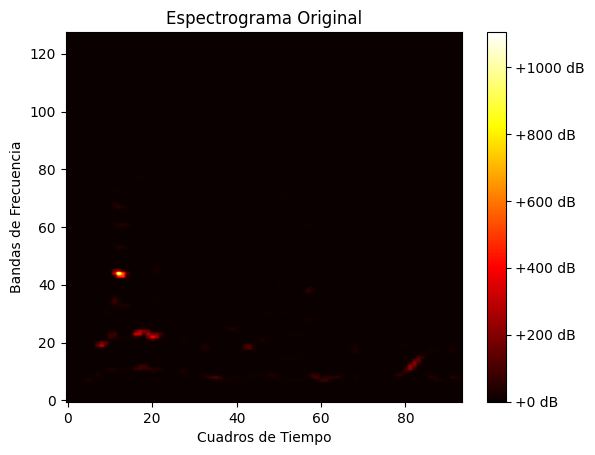

<class 'numpy.ndarray'>
(128, 94)


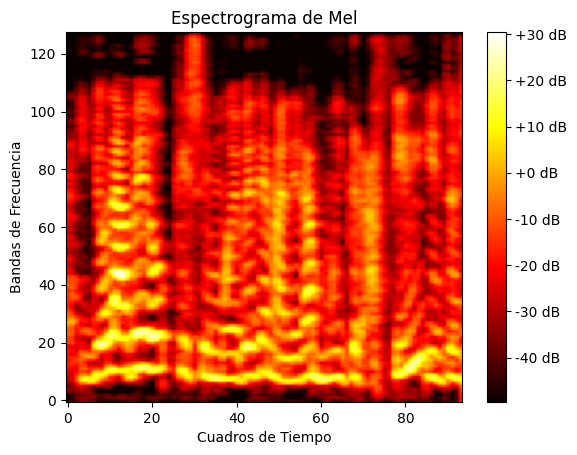

In [10]:

import librosa
import numpy as np
import random
import colorednoise as cn
import os
import matplotlib.pyplot as plt
import soundfile as sf
from Preprocessing import colored_noise


sample_rate = 16000
seconds = 3
start = 20
ter_audio, _ = librosa.load('ter.wav', sr=sample_rate)
ter_audio = ter_audio[start*sample_rate:sample_rate*(seconds+start)]

# Mostrar la waveform
print(type(ter_audio))
print(ter_audio.shape)
plt.figure(figsize=(10, 4))
librosa.display.waveshow(ter_audio, sr=sample_rate)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Forma de onda original')
plt.show()



spectrogram = librosa.feature.melspectrogram(y=ter_audio, sr=sample_rate)
# Show spectrogram
print(type(spectrogram))
print(spectrogram.shape)
plt.imshow(spectrogram, cmap='hot', aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f dB')  # Barra de color opcional
plt.xlabel('Cuadros de Tiempo')
plt.ylabel('Bandas de Frecuencia')
plt.title('Espectrograma Original')
plt.show()



original_melspec = librosa.power_to_db(spectrogram)  # Original mel spectrogram
# Show spectrogram
print(type(original_melspec))
print(original_melspec.shape)
plt.imshow(original_melspec, cmap='hot', aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f dB')  # Barra de color opcional
plt.xlabel('Cuadros de Tiempo')
plt.ylabel('Bandas de Frecuencia')
plt.title('Espectrograma de Mel')
plt.show()

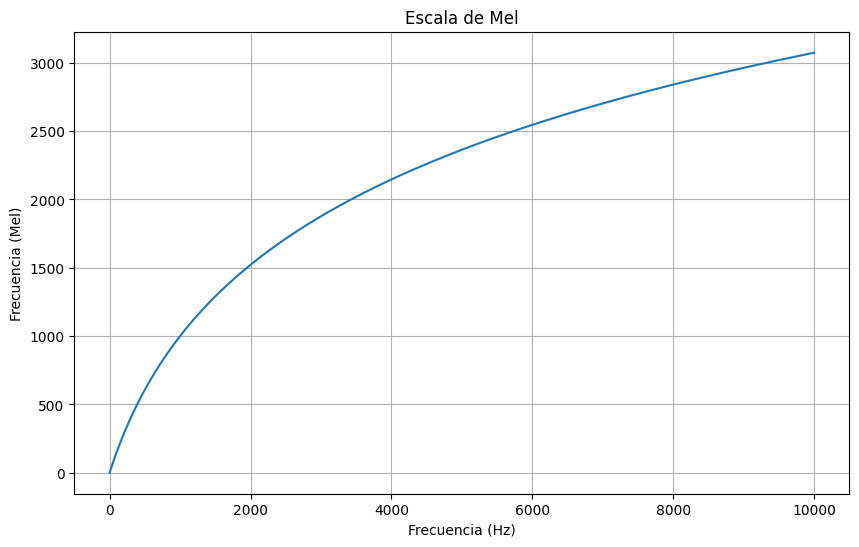

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the Mel scale
num_mel_bins = 10000  # Number of Mel bins
sample_rate = 44100  # Sample rate in Hz

# Compute the Mel scale frequencies
mel_frequencies = 1127.01048 * np.log(1 + np.arange(0, num_mel_bins + 2) / 700)

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(range(num_mel_bins + 2), mel_frequencies)

# Add labels and title
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Frecuencia (Mel)')
plt.title('Escala de Mel')

plt.grid(True)
plt.show()